## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats
import models
import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
epoch_num=50
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import squidpy as sq
from sklearn.preprocessing import normalize
from scipy import stats

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
sc.set_figure_params(scanpy=True, fontsize=16)
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


<h3>Download the dataset from scvi-tools</h3>

In [3]:
import scvi
adata = scvi.data.retina()
adata

Global seed set to 0


INFO     File /Users/jonathankarin/PycharmProjects/training_dyn/data/retina.loom already downloaded                


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scvi/data/_built_in_data/_loom.py:154: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X=data, obs=obs_dict, var=var_dict, uns=uns_dict, obsm=obsm_dict)


AnnData object with n_obs × n_vars = 19829 × 13166
    obs: 'labels', 'batch'
    uns: 'CreationDate', 'LOOM_SPEC_VERSION', 'last_modified'

<h3> Standard preprocessing</h3>

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var['highly_variable']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


<h3> Visualization</h3>

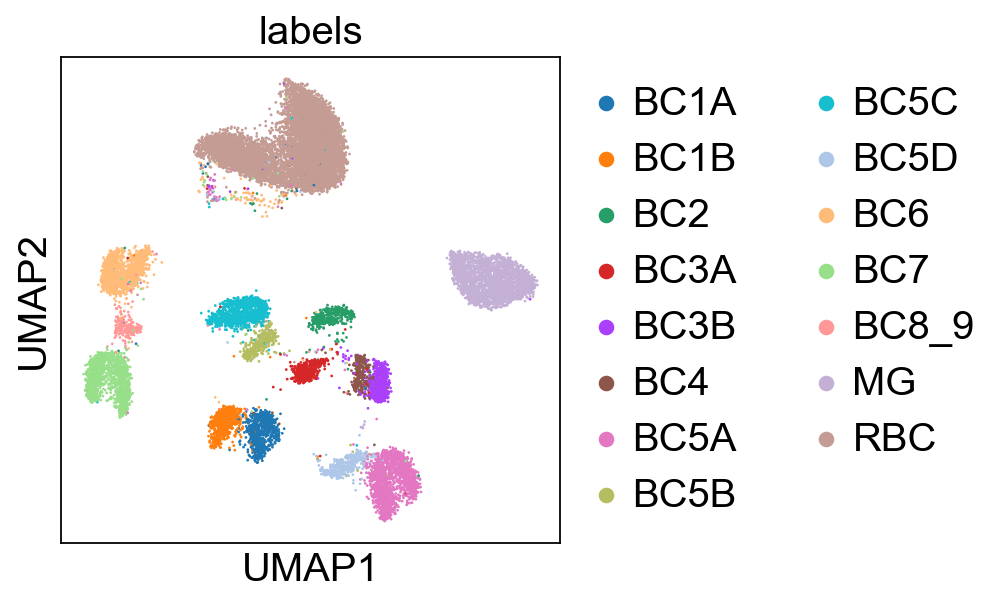

In [5]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=['labels'])

In [6]:
adata

AnnData object with n_obs × n_vars = 19829 × 3000
    obs: 'labels', 'batch', 'n_counts'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'CreationDate', 'LOOM_SPEC_VERSION', 'last_modified', 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'labels_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

<h3> Train the neural network and monitor the training dynamics</h3>
You can adjust the following parameters:<br />
"iterNum"- number of epochs.<br />
"lr"=learning rate, default is 0.001 <br />
"momentum"- default is 0.9,<br />
"device"- cuda device, default is 'cpu' <br />
"weighted_sampler"- use weighted sampler or not, default is True<br />
"batch_size"- default is 256

In [7]:
epoch_num=100
prob_list = models.follow_training_dyn_neural_net(adata, label_key='labels',iterNum=epoch_num, device=device)

/Users/jonathankarin/PycharmProjects/training_dyn/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.542
[1,    12] loss: 2.706
[1,    22] loss: 2.681
[1,    32] loss: 2.653
[1,    42] loss: 2.619
[1,    52] loss: 2.585
[1,    62] loss: 2.545
[1,    72] loss: 2.504
[2,     2] loss: 0.490
[2,    12] loss: 2.401
[2,    22] loss: 2.340
[2,    32] loss: 2.273
[2,    42] loss: 2.220
[2,    52] loss: 2.118
[2,    62] loss: 2.043
[2,    72] loss: 1.929
[3,     2] loss: 0.369
[3,    12] loss: 1.755
[3,    22] loss: 1.640
[3,    32] loss: 1.503
[3,    42] loss: 1.400
[3,    52] loss: 1.259
[3,    62] loss: 1.161
[3,    72] loss: 1.064
[4,     2] loss: 0.181
[4,    12] loss: 0.860
[4,    22] loss: 0.765
[4,    32] loss: 0.704
[4,    42] loss: 0.636
[4,    52] loss: 0.581
[4,    62] loss: 0.527
[4,    72] loss: 0.489
[5,     2] loss: 0.081
[5,    12] loss: 0.420
[5,    22] loss: 0.392
[5,    32] loss: 0.357
[5,    42] loss: 0.339
[5,    52] loss: 0.314
[5,    62] loss: 0.302
[5,    72] loss: 0.286
[6,     2] loss: 0.054
[6,    12] loss: 0.266
[6,    22] loss: 0.246
[6,    32] 

[44,    12] loss: 0.011
[44,    22] loss: 0.010
[44,    32] loss: 0.010
[44,    42] loss: 0.011
[44,    52] loss: 0.010
[44,    62] loss: 0.010
[44,    72] loss: 0.009
[45,     2] loss: 0.002
[45,    12] loss: 0.010
[45,    22] loss: 0.009
[45,    32] loss: 0.011
[45,    42] loss: 0.010
[45,    52] loss: 0.011
[45,    62] loss: 0.010
[45,    72] loss: 0.010
[46,     2] loss: 0.002
[46,    12] loss: 0.010
[46,    22] loss: 0.010
[46,    32] loss: 0.008
[46,    42] loss: 0.010
[46,    52] loss: 0.010
[46,    62] loss: 0.008
[46,    72] loss: 0.011
[47,     2] loss: 0.002
[47,    12] loss: 0.009
[47,    22] loss: 0.009
[47,    32] loss: 0.009
[47,    42] loss: 0.010
[47,    52] loss: 0.008
[47,    62] loss: 0.010
[47,    72] loss: 0.011
[48,     2] loss: 0.002
[48,    12] loss: 0.008
[48,    22] loss: 0.008
[48,    32] loss: 0.010
[48,    42] loss: 0.013
[48,    52] loss: 0.008
[48,    62] loss: 0.008
[48,    72] loss: 0.008
[49,     2] loss: 0.001
[49,    12] loss: 0.008
[49,    22] loss

[86,    72] loss: 0.004
[87,     2] loss: 0.001
[87,    12] loss: 0.004
[87,    22] loss: 0.003
[87,    32] loss: 0.004
[87,    42] loss: 0.004
[87,    52] loss: 0.004
[87,    62] loss: 0.004
[87,    72] loss: 0.004
[88,     2] loss: 0.001
[88,    12] loss: 0.004
[88,    22] loss: 0.003
[88,    32] loss: 0.004
[88,    42] loss: 0.004
[88,    52] loss: 0.003
[88,    62] loss: 0.004
[88,    72] loss: 0.004
[89,     2] loss: 0.001
[89,    12] loss: 0.004
[89,    22] loss: 0.004
[89,    32] loss: 0.004
[89,    42] loss: 0.004
[89,    52] loss: 0.004
[89,    62] loss: 0.005
[89,    72] loss: 0.003
[90,     2] loss: 0.001
[90,    12] loss: 0.004
[90,    22] loss: 0.004
[90,    32] loss: 0.004
[90,    42] loss: 0.003
[90,    52] loss: 0.003
[90,    62] loss: 0.003
[90,    72] loss: 0.003
[91,     2] loss: 0.001
[91,    12] loss: 0.003
[91,    22] loss: 0.003
[91,    32] loss: 0.004
[91,    42] loss: 0.003
[91,    52] loss: 0.003
[91,    62] loss: 0.003
[91,    72] loss: 0.004
[92,     2] loss

In [8]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)

<h4>Visualize the datamap</h4>

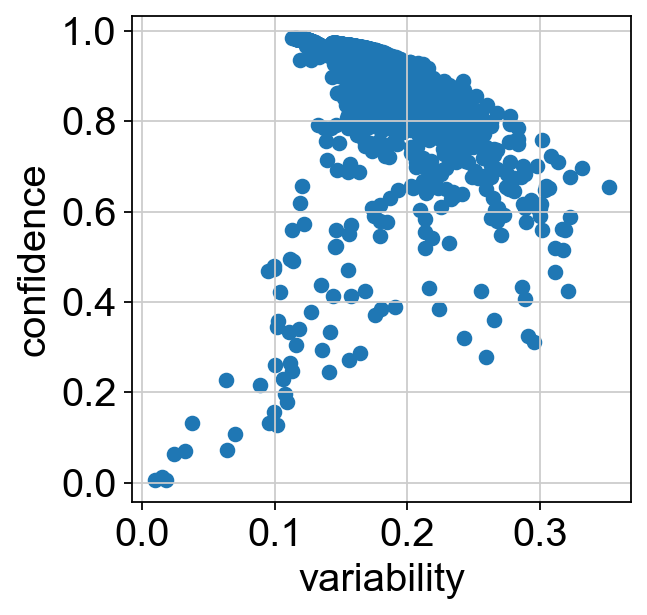

In [9]:
plt.scatter( all_var.detach().numpy(),all_conf.detach().numpy())
plt.xlabel('variability')
plt.ylabel('confidence')
plt.show()


In [10]:
adata.obs["var"] = list(all_var.detach().numpy())
adata.obs["conf"] = list(all_conf.detach().numpy())


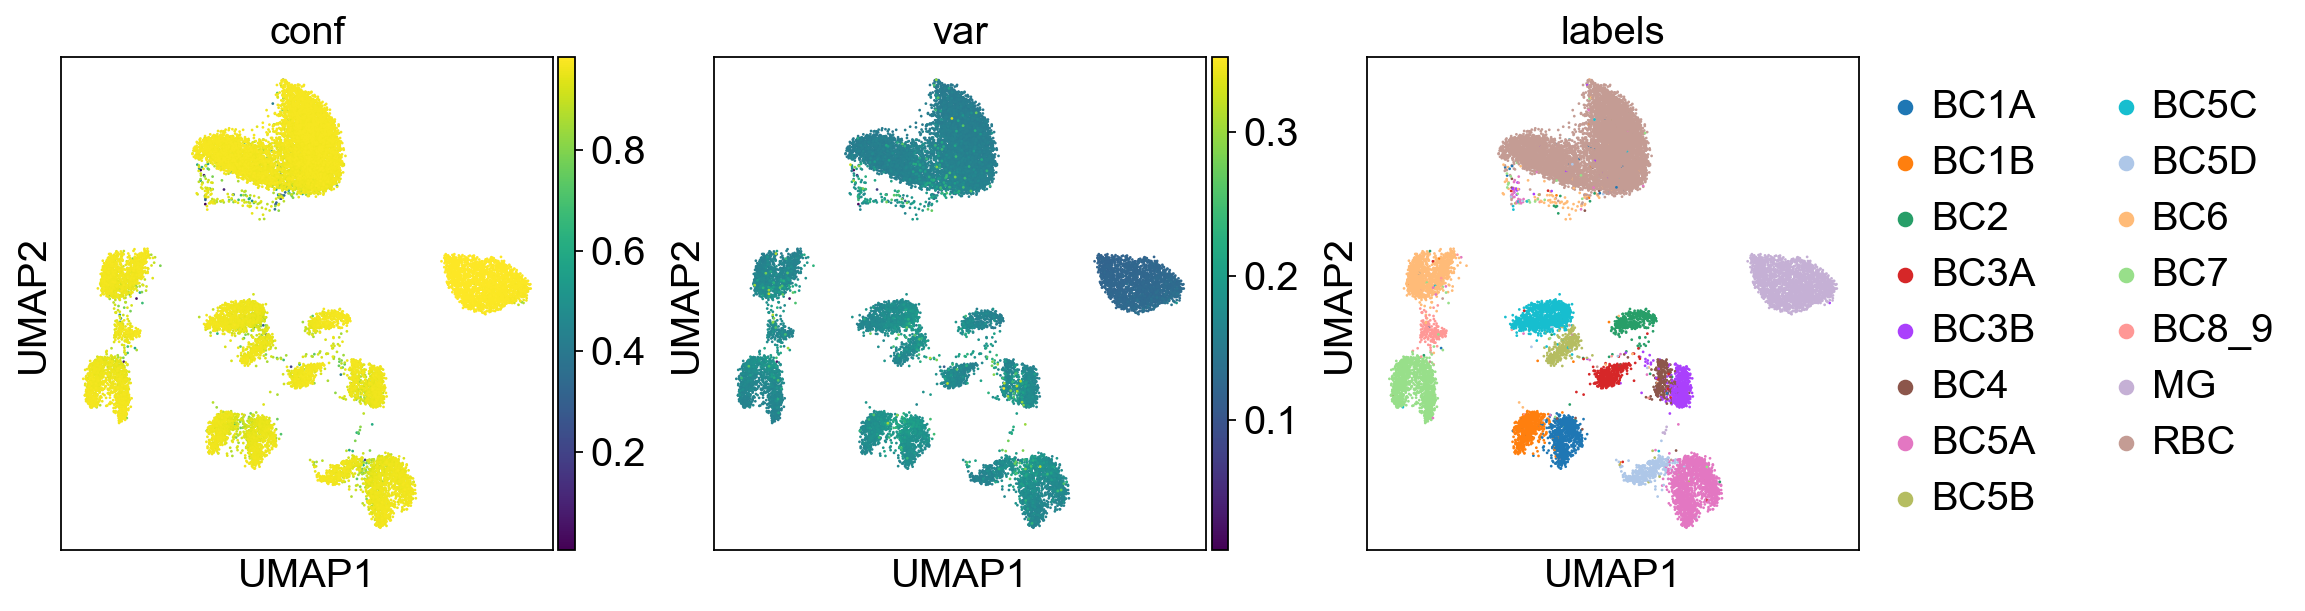

In [11]:
sc.pl.umap(adata,color=['conf','var','labels'])


BC3B


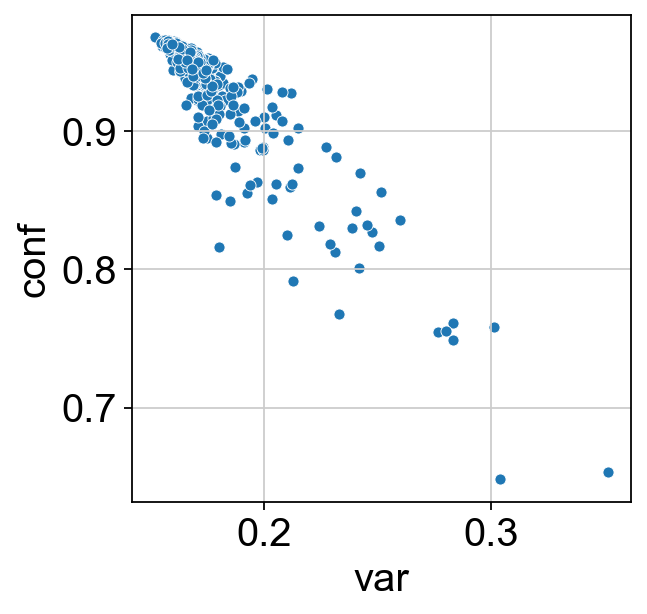

BC1B


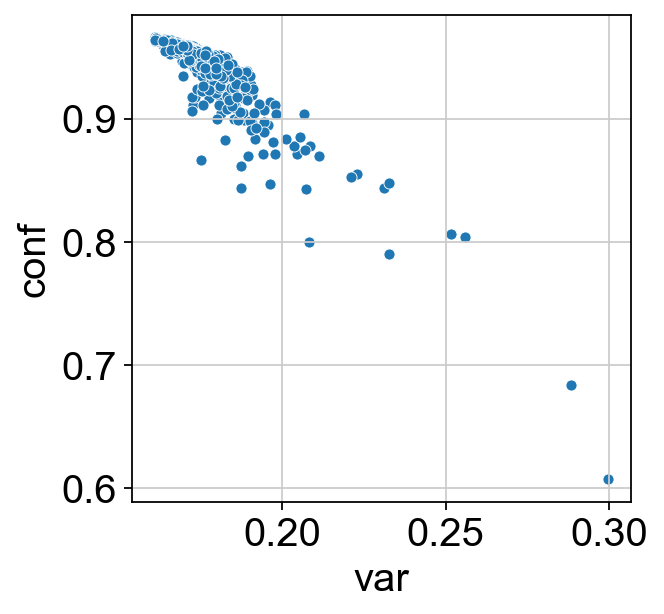

BC1A


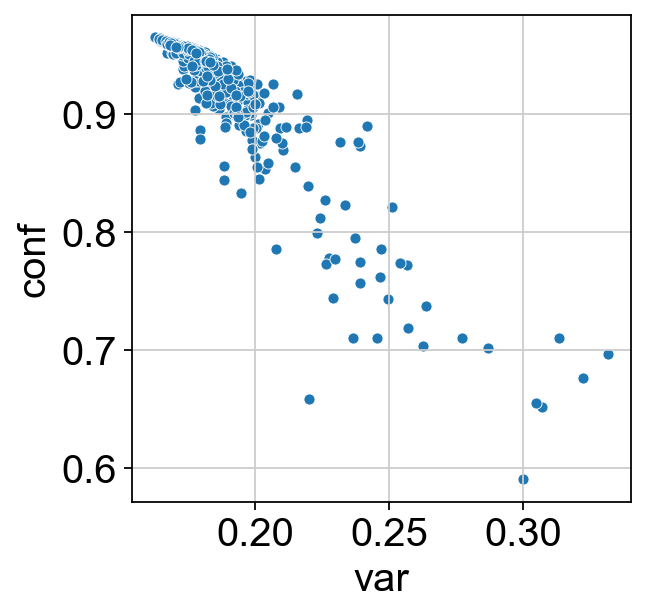

BC5C


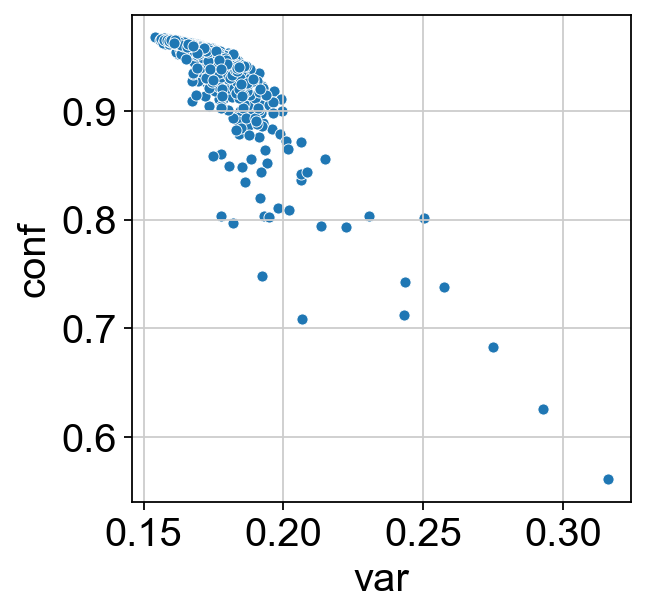

BC4


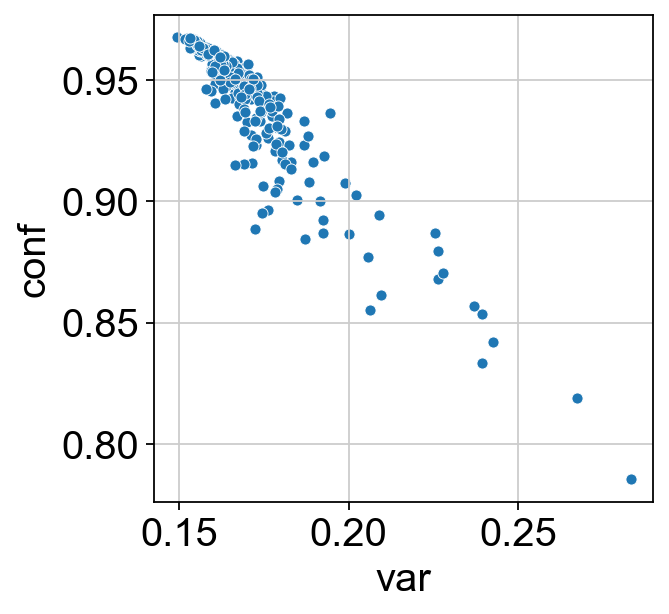

BC8_9


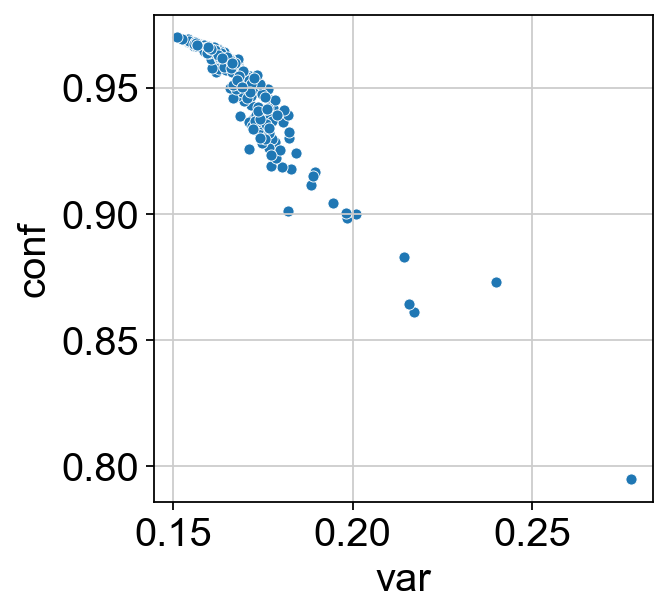

RBC


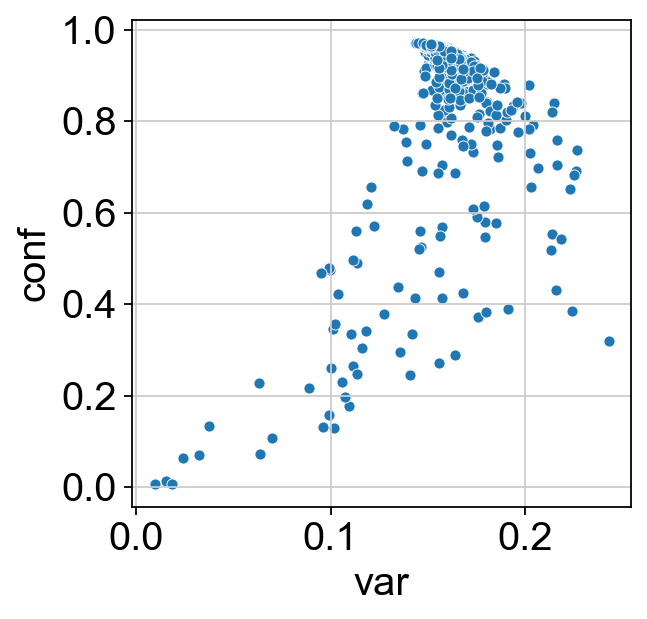

BC3A


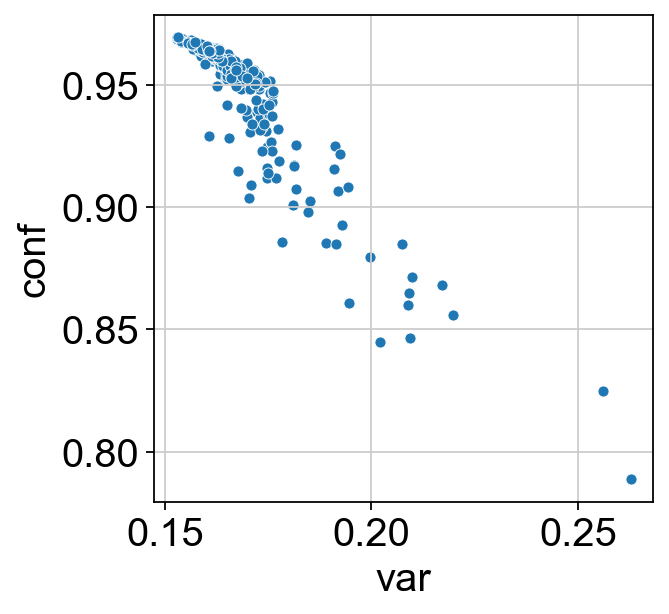

BC2


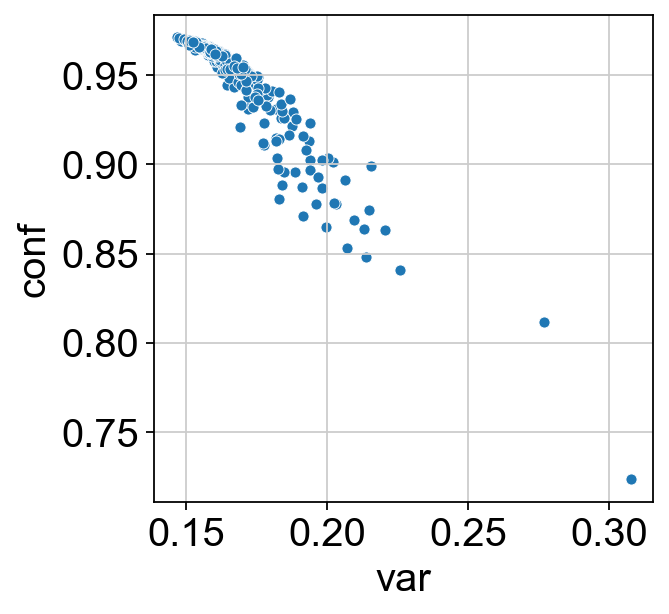

BC5B


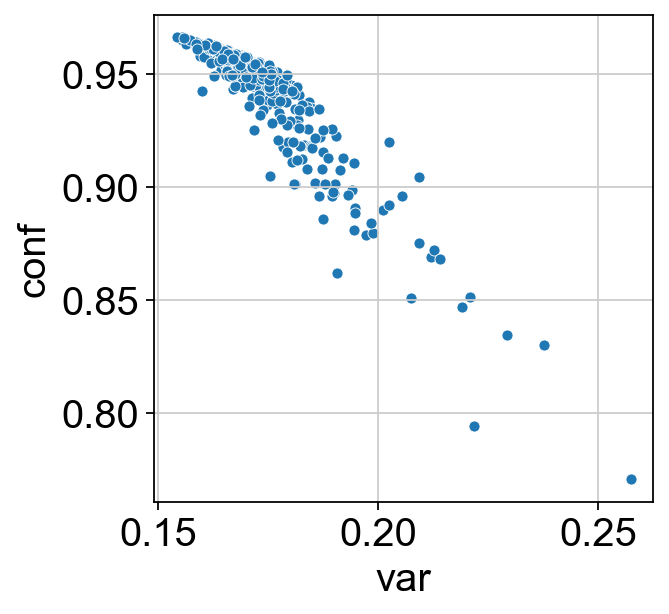

BC5A


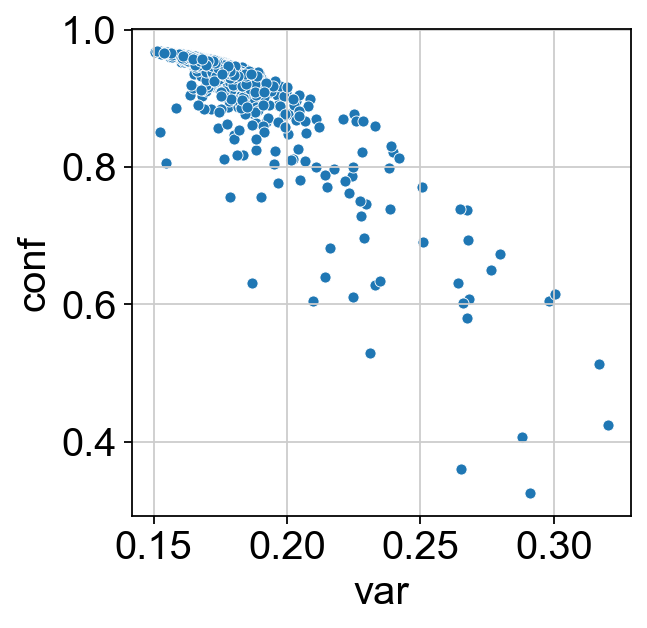

BC6


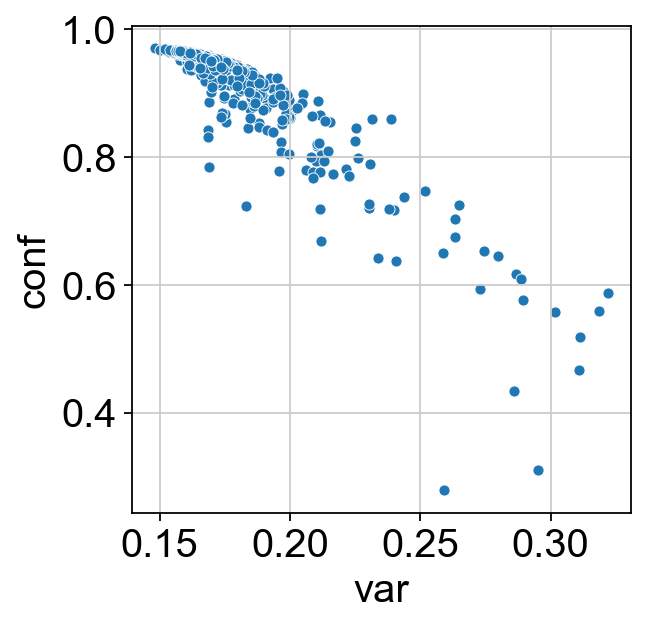

MG


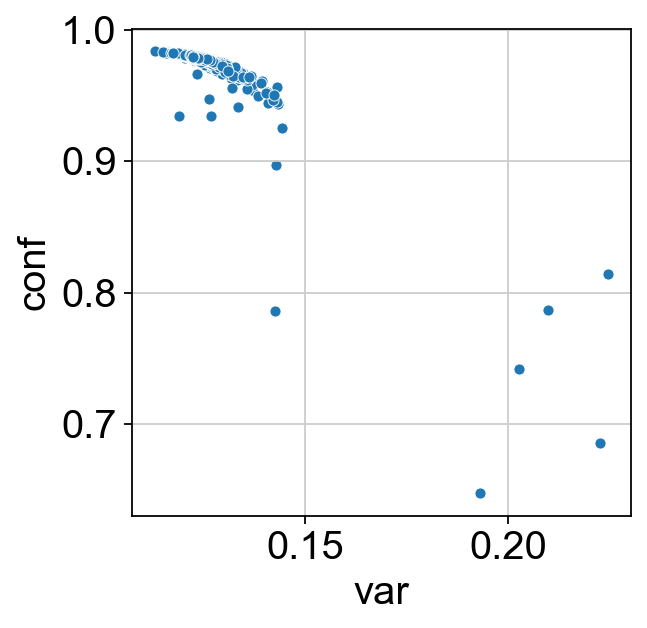

BC5D


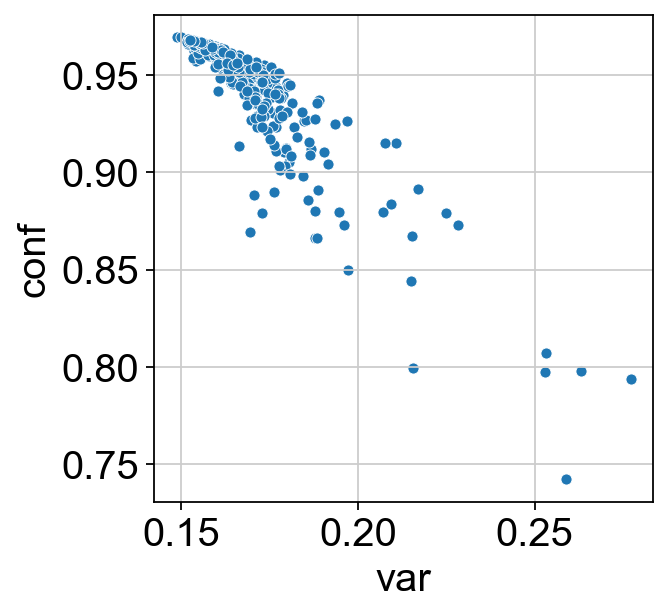

BC7


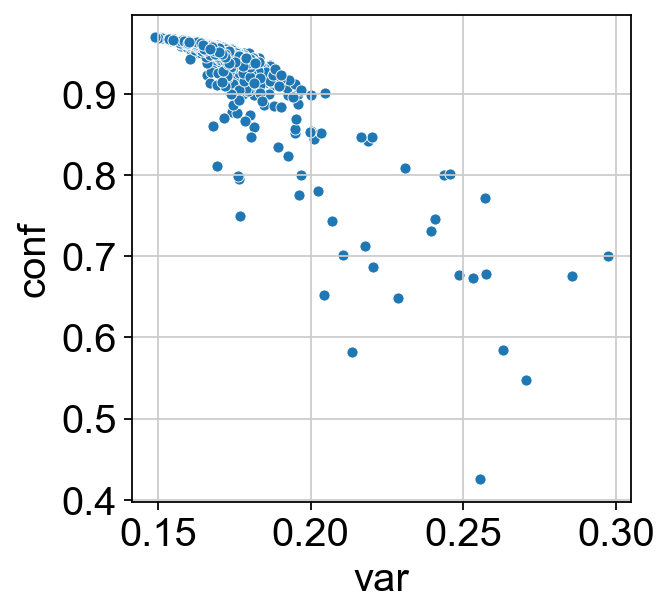

In [13]:
for i in set(list(adata.obs['labels'])):
    print(i)
    adata_tmp = adata[adata.obs['labels'].isin([i])]
    fig = sns.scatterplot(data=adata_tmp.obs, x="var", y="conf",s=25)
    plt.show()

Find the cutoff, cells with confidence lower than the cutoff and varibility lower than the cutoff will be classified as hard-to-learn.

In [14]:
conf, var = models.find_cutoff_paramter(adata,'labels', device=device, probability=0.05,percentile=50, epoch_num=epoch_num)

/Users/jonathankarin/PycharmProjects/training_dyn/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.540
[1,    12] loss: 2.701
[1,    22] loss: 2.682
[1,    32] loss: 2.660
[1,    42] loss: 2.627
[1,    52] loss: 2.602
[1,    62] loss: 2.564
[1,    72] loss: 2.535
[2,     2] loss: 0.499
[2,    12] loss: 2.449
[2,    22] loss: 2.406
[2,    32] loss: 2.359
[2,    42] loss: 2.301
[2,    52] loss: 2.248
[2,    62] loss: 2.168
[2,    72] loss: 2.100
[3,     2] loss: 0.416
[3,    12] loss: 1.993
[3,    22] loss: 1.923
[3,    32] loss: 1.811
[3,    42] loss: 1.758
[3,    52] loss: 1.681
[3,    62] loss: 1.584
[3,    72] loss: 1.506
[4,     2] loss: 0.279
[4,    12] loss: 1.343
[4,    22] loss: 1.298
[4,    32] loss: 1.243
[4,    42] loss: 1.159
[4,    52] loss: 1.102
[4,    62] loss: 1.065
[4,    72] loss: 1.011
[5,     2] loss: 0.211
[5,    12] loss: 1.001
[5,    22] loss: 0.970
[5,    32] loss: 0.936
[5,    42] loss: 0.886
[5,    52] loss: 0.864
[5,    62] loss: 0.845
[5,    72] loss: 0.815
[6,     2] loss: 0.154
[6,    12] loss: 0.842
[6,    22] loss: 0.814
[6,    32] 

[44,    12] loss: 0.136
[44,    22] loss: 0.109
[44,    32] loss: 0.105
[44,    42] loss: 0.113
[44,    52] loss: 0.128
[44,    62] loss: 0.116
[44,    72] loss: 0.113
[45,     2] loss: 0.022
[45,    12] loss: 0.109
[45,    22] loss: 0.113
[45,    32] loss: 0.110
[45,    42] loss: 0.112
[45,    52] loss: 0.127
[45,    62] loss: 0.121
[45,    72] loss: 0.125
[46,     2] loss: 0.021
[46,    12] loss: 0.102
[46,    22] loss: 0.122
[46,    32] loss: 0.105
[46,    42] loss: 0.107
[46,    52] loss: 0.124
[46,    62] loss: 0.109
[46,    72] loss: 0.106
[47,     2] loss: 0.016
[47,    12] loss: 0.100
[47,    22] loss: 0.102
[47,    32] loss: 0.100
[47,    42] loss: 0.100
[47,    52] loss: 0.106
[47,    62] loss: 0.105
[47,    72] loss: 0.096
[48,     2] loss: 0.023
[48,    12] loss: 0.111
[48,    22] loss: 0.099
[48,    32] loss: 0.113
[48,    42] loss: 0.101
[48,    52] loss: 0.112
[48,    62] loss: 0.091
[48,    72] loss: 0.095
[49,     2] loss: 0.018
[49,    12] loss: 0.107
[49,    22] loss

[86,    72] loss: 0.029
[87,     2] loss: 0.008
[87,    12] loss: 0.028
[87,    22] loss: 0.037
[87,    32] loss: 0.033
[87,    42] loss: 0.035
[87,    52] loss: 0.034
[87,    62] loss: 0.039
[87,    72] loss: 0.027
[88,     2] loss: 0.006
[88,    12] loss: 0.039
[88,    22] loss: 0.028
[88,    32] loss: 0.034
[88,    42] loss: 0.040
[88,    52] loss: 0.030
[88,    62] loss: 0.031
[88,    72] loss: 0.033
[89,     2] loss: 0.006
[89,    12] loss: 0.028
[89,    22] loss: 0.028
[89,    32] loss: 0.029
[89,    42] loss: 0.029
[89,    52] loss: 0.038
[89,    62] loss: 0.028
[89,    72] loss: 0.024
[90,     2] loss: 0.005
[90,    12] loss: 0.024
[90,    22] loss: 0.041
[90,    32] loss: 0.025
[90,    42] loss: 0.033
[90,    52] loss: 0.034
[90,    62] loss: 0.027
[90,    72] loss: 0.031
[91,     2] loss: 0.006
[91,    12] loss: 0.028
[91,    22] loss: 0.030
[91,    32] loss: 0.038
[91,    42] loss: 0.028
[91,    52] loss: 0.029
[91,    62] loss: 0.022
[91,    72] loss: 0.022
[92,     2] loss

In [15]:
conf, var

(0.5472422242164612, 0.33244380354881287)

In [17]:
adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > conf) |  (adata.obs['var'] > var))


Mark which cells are correctly annotated. We will defined cells that are not either correctly annotated or crroneously annotated as ambiguous annotation.

In [41]:
adata.obs['conf_correct'] = pd.Categorical((adata.obs['conf'] > 0.95) &  (adata.obs['var'] < 0.2))


In [42]:
adata.obs['conf_binaries'].value_counts()

True     19764
False       65
Name: conf_binaries, dtype: int64

In [43]:
adata.obs['conf_correct'].value_counts()

True     15378
False     4451
Name: conf_correct, dtype: int64

In [44]:
corr_classified_list =[]
for i in range(adata.n_obs):
    if adata.obs['conf_binaries'][i]==False:
        corr_classified_list.append('Erroneously annotated')
    else:
        if adata.obs['conf_correct'][i]==False:
            corr_classified_list.append('Ambiguous annotation')
        else:
            corr_classified_list.append('Correctly annotated')

adata.obs['Annotation']=corr_classified_list

In [45]:
adata.obs['Confidence']=adata.obs['conf']
adata.obs['Variability']=adata.obs['var']

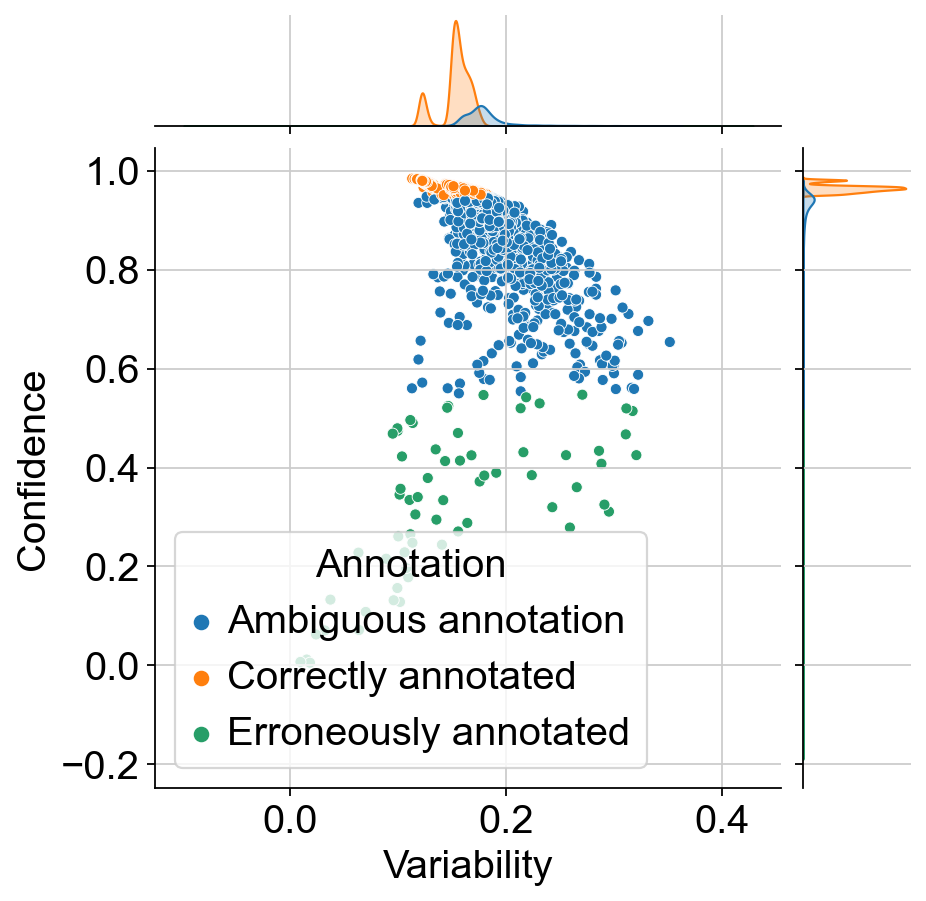

In [46]:
fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='Annotation',s=25)
plt.show(fig)

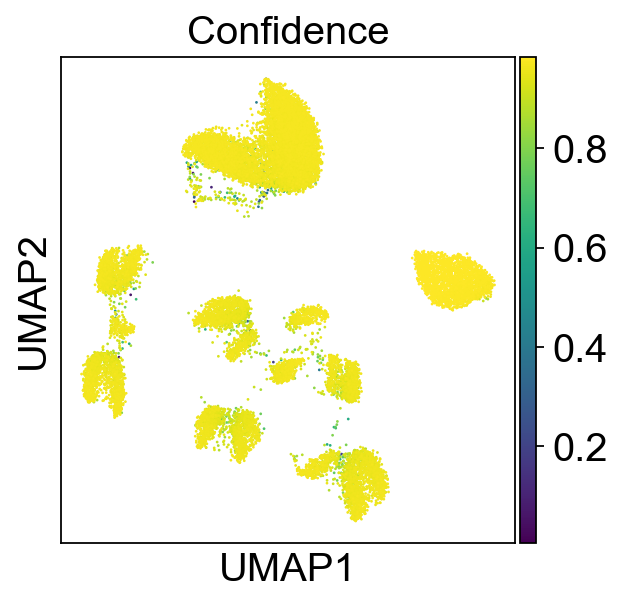

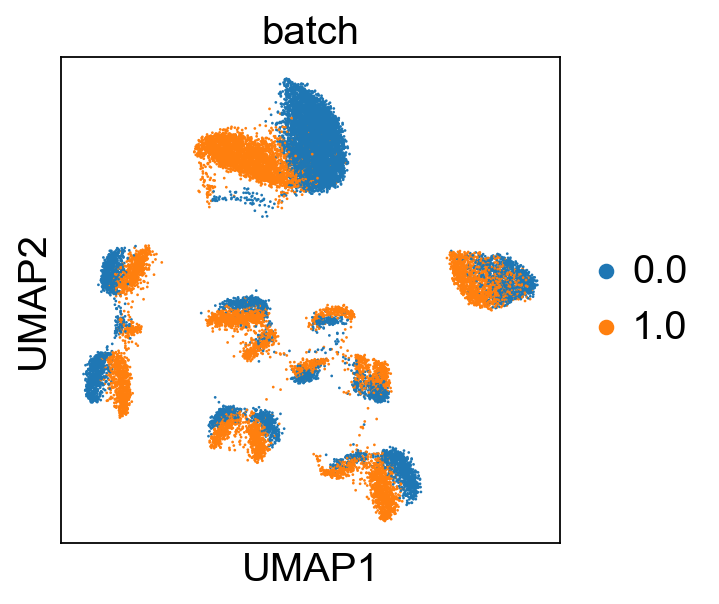

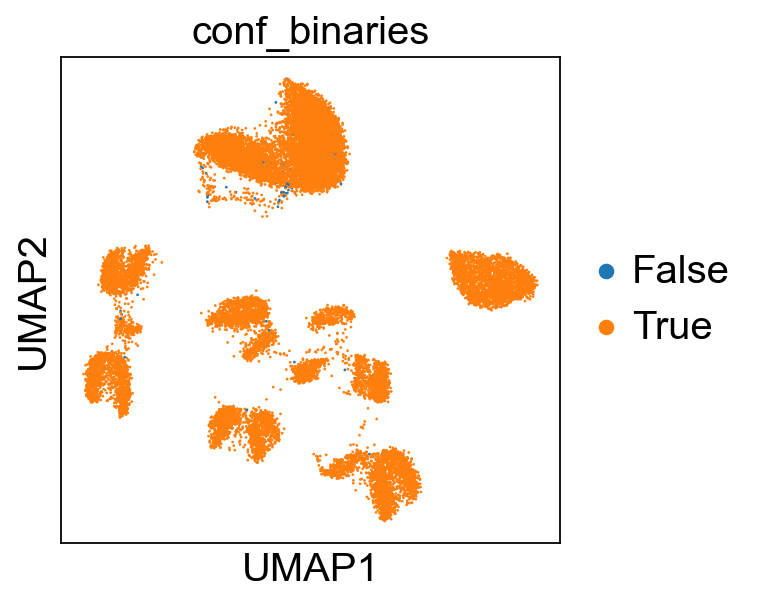

In [47]:
sc.pl.umap(adata,color=['conf'], title='Confidence')
sc.pl.umap(adata,color=['batch'])
sc.pl.umap(adata,color=['conf_binaries'])


Filter out erroneously annotated cells

In [48]:
orig_adata = adata.copy()
adata= adata[adata.obs['conf_binaries'].isin([True])]

We will anaylze the intermediate states between 'BC1A' and'BC1B'.


In [49]:
adata_bc1ab = adata[adata.obs['labels'].isin(['BC1A',
 'BC1B'])]


In [50]:
adata_bc1a = adata[adata.obs['labels'].isin(['BC1A'])]
adata_bc1b = adata[adata.obs['labels'].isin(['BC1B'])]


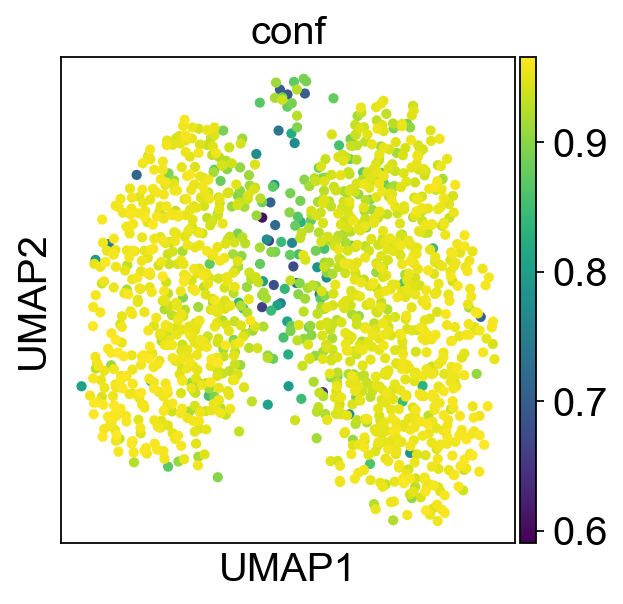

In [51]:
sc.pp.pca(adata_bc1ab)
sc.pp.neighbors(adata_bc1ab)
sc.tl.umap(adata_bc1ab)
sc.pl.umap(adata_bc1ab, color='conf')

<h3> Create the trainability-aware graph-embedding which combines the confidence and the gene expression</h3>
"alpha"- tunable parameter (0 ≤ α ≤ 1), which interpolates between a gene expression-based distance matrix (α=1) and a trainabilitybased distance matrix (α=0).<br />
"k"- amount of neigbors for the KNN graph.

In [52]:
adata_bc1ab_graph = adata_bc1ab.copy()
sc.pp.pca(adata_bc1ab)
sc.pp.neighbors(adata_bc1ab)
connectivities_graph , distance_graph  = metrics.make_conf_graph(adata_bc1ab_graph.copy(), alpha=0.75 , k=15)

adata_bc1ab_graph.obsp['connectivities']=sp.csr_matrix(connectivities_graph)

sc.tl.umap(adata_bc1ab_graph)
sc.tl.umap(adata_bc1ab)


In [53]:
sc.tl.louvain(adata_bc1ab_graph, resolution=0.3)

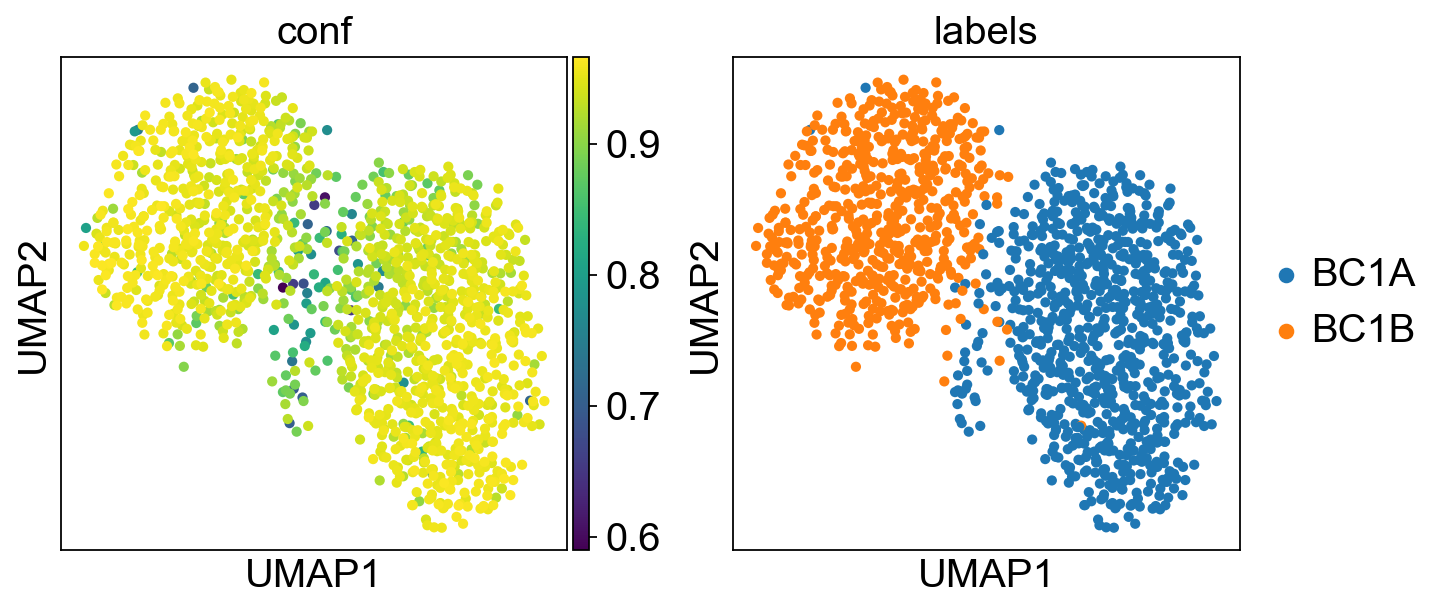

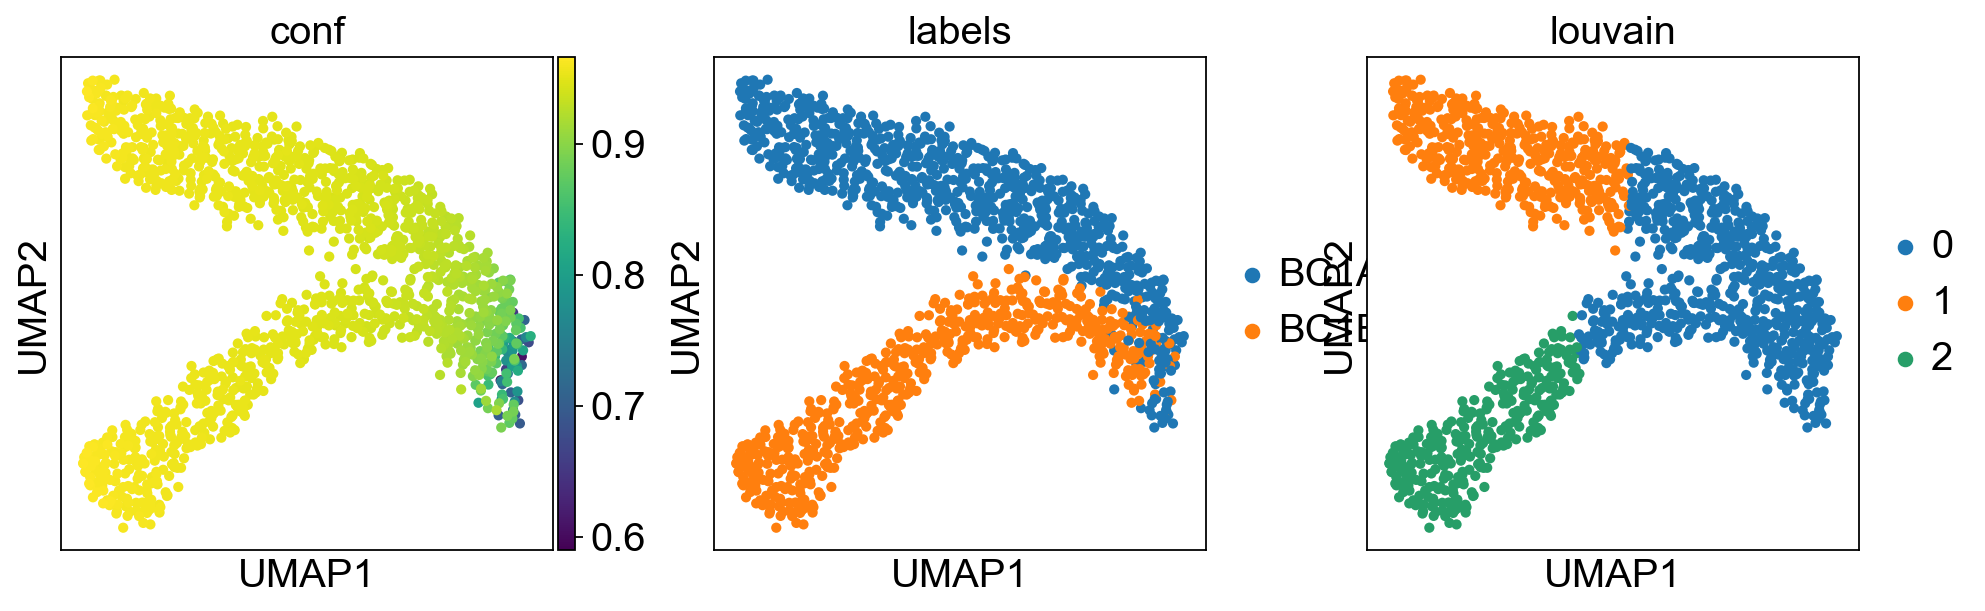

In [54]:
sc.pl.umap(adata_bc1ab, color=['conf','labels'])


sc.pl.umap(adata_bc1ab_graph, color=['conf','labels','louvain'])


<h3>Find annotation-trainability associated genes</h3> 
The annotation-trainability positive association score would be stored as adata_bc1ab_ranked.var['conf_score_high'] and the annotation-trainability negative association score would be stored as adata_bc1ab_ranked.var['conf_score_low'].

In [55]:
adata_bc1ab_ranked = metrics.rank_genes_conf_min_counts(adata_bc1ab, 1,1)
adata_bc1a_ranked = metrics.rank_genes_conf_min_counts(adata_bc1a, 1,1)
adata_bc1b_ranked = metrics.rank_genes_conf_min_counts(adata_bc1b, 1,1)


In [56]:
adata_bc1ab_ranked.var['conf_score_low'].sort_values(ascending=False).index[:10]

Index(['5851', '7364', '13154', '639', '5223', '2505', '8778', '11899', '1955',
       '7113'],
      dtype='object')

In [57]:
adata_bc1ab_ranked.var['conf_score_high'].sort_values(ascending=False).index[:10]

Index(['7326', '10358', '11157', '12507', '9610', '8743', '6280', '1899',
       '3221', '4414'],
      dtype='object')

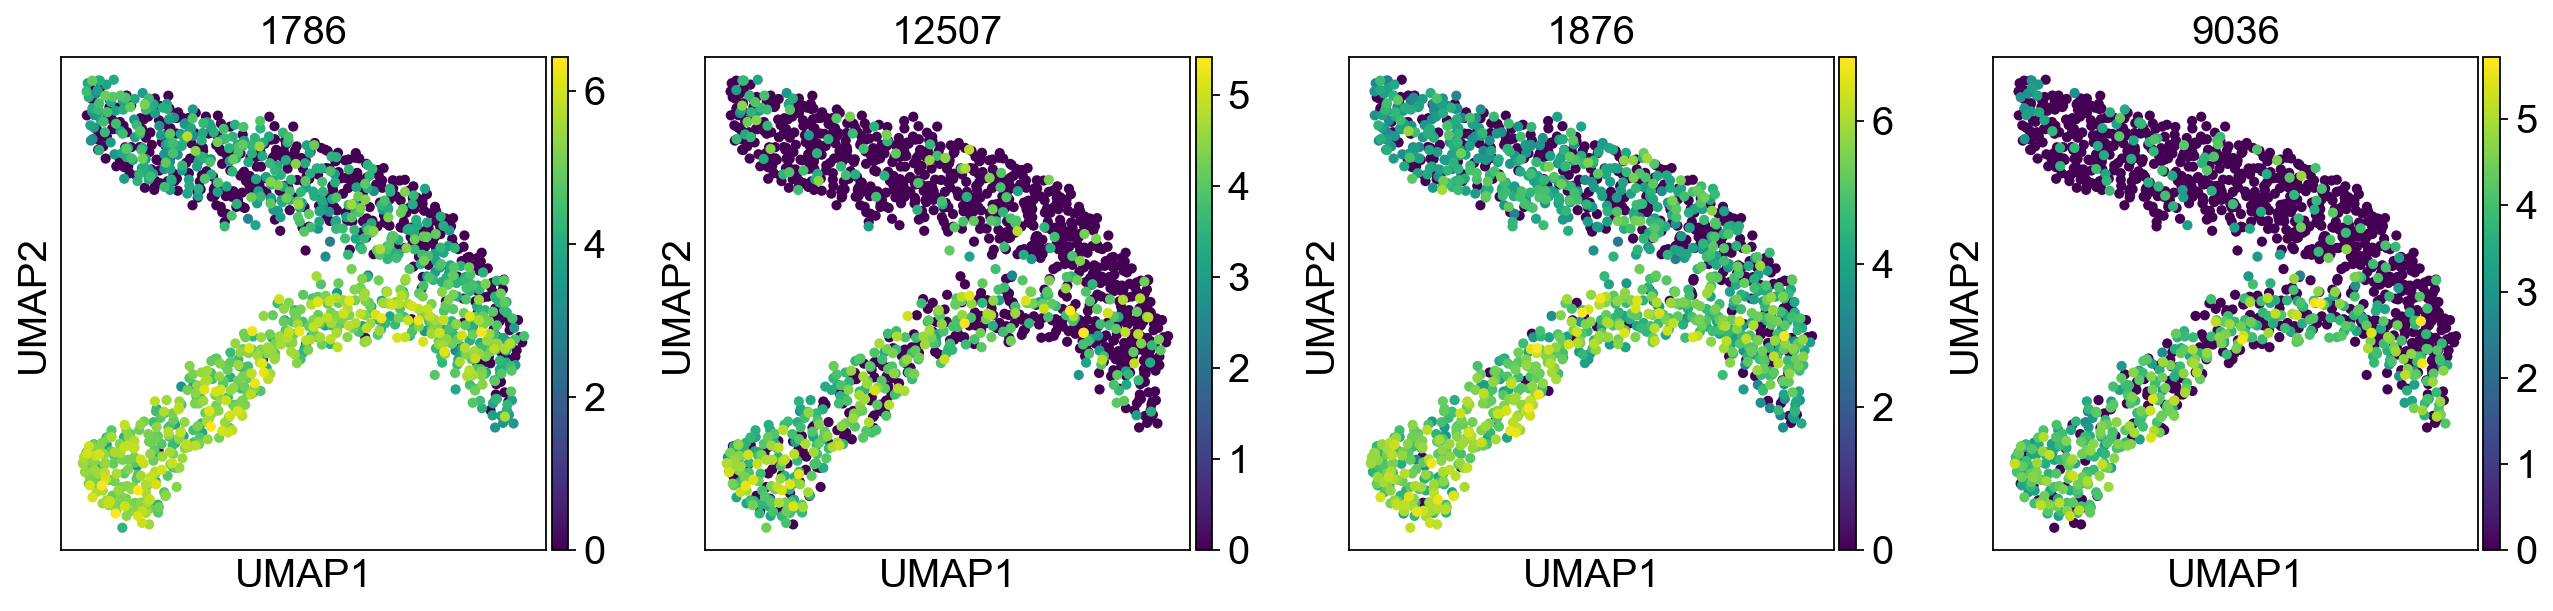

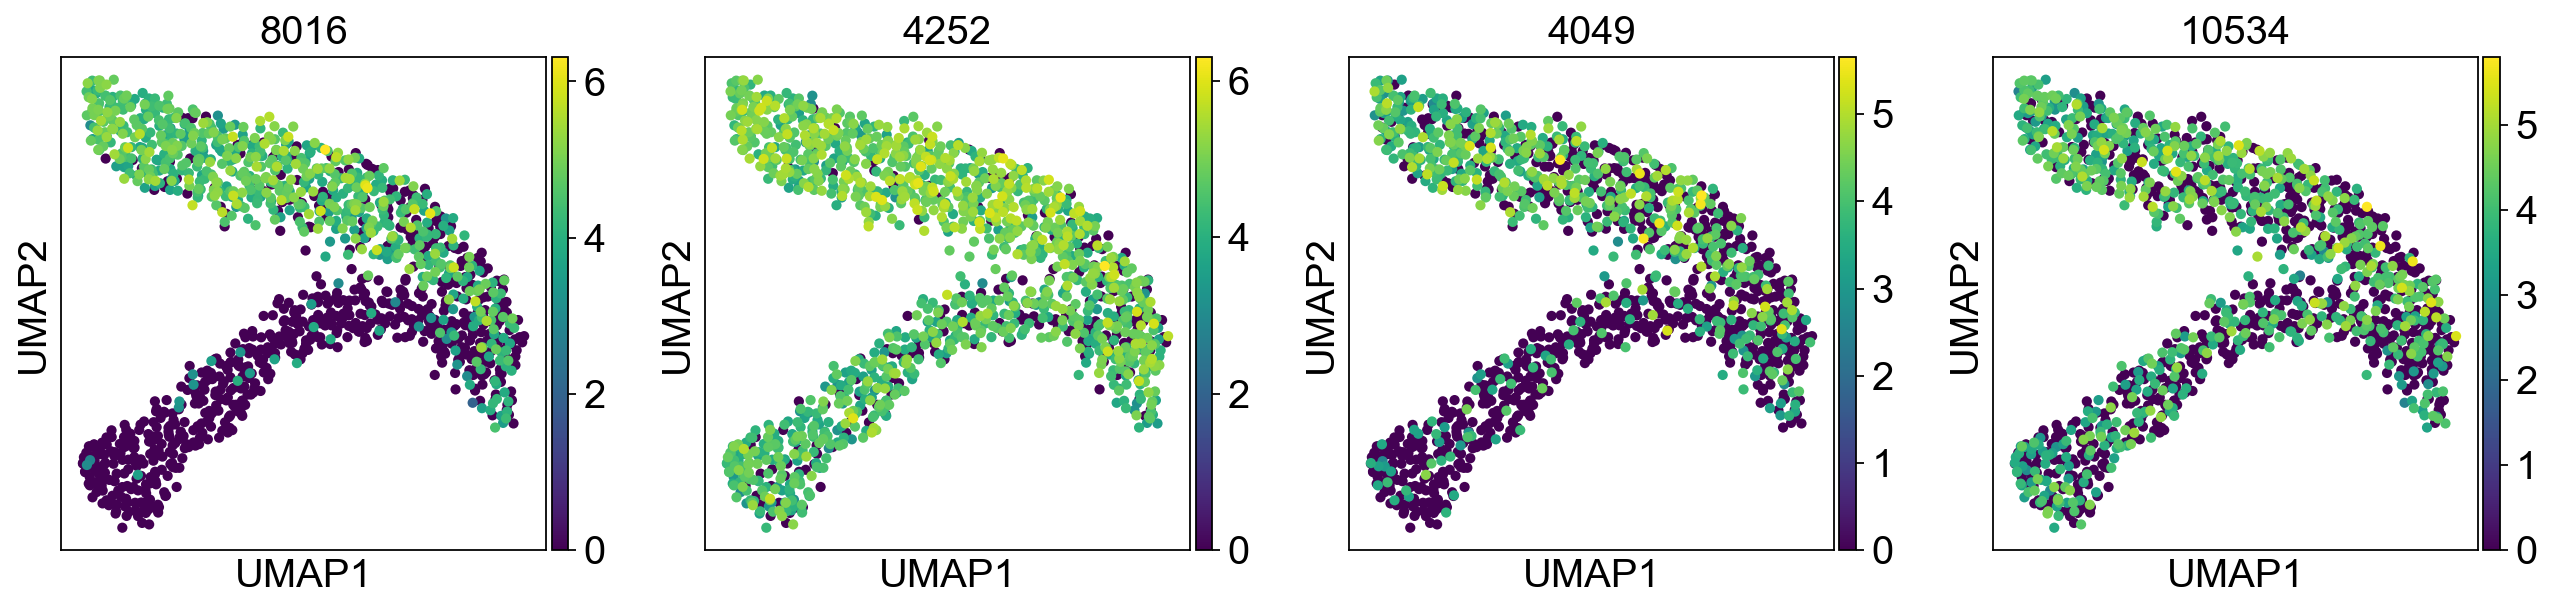

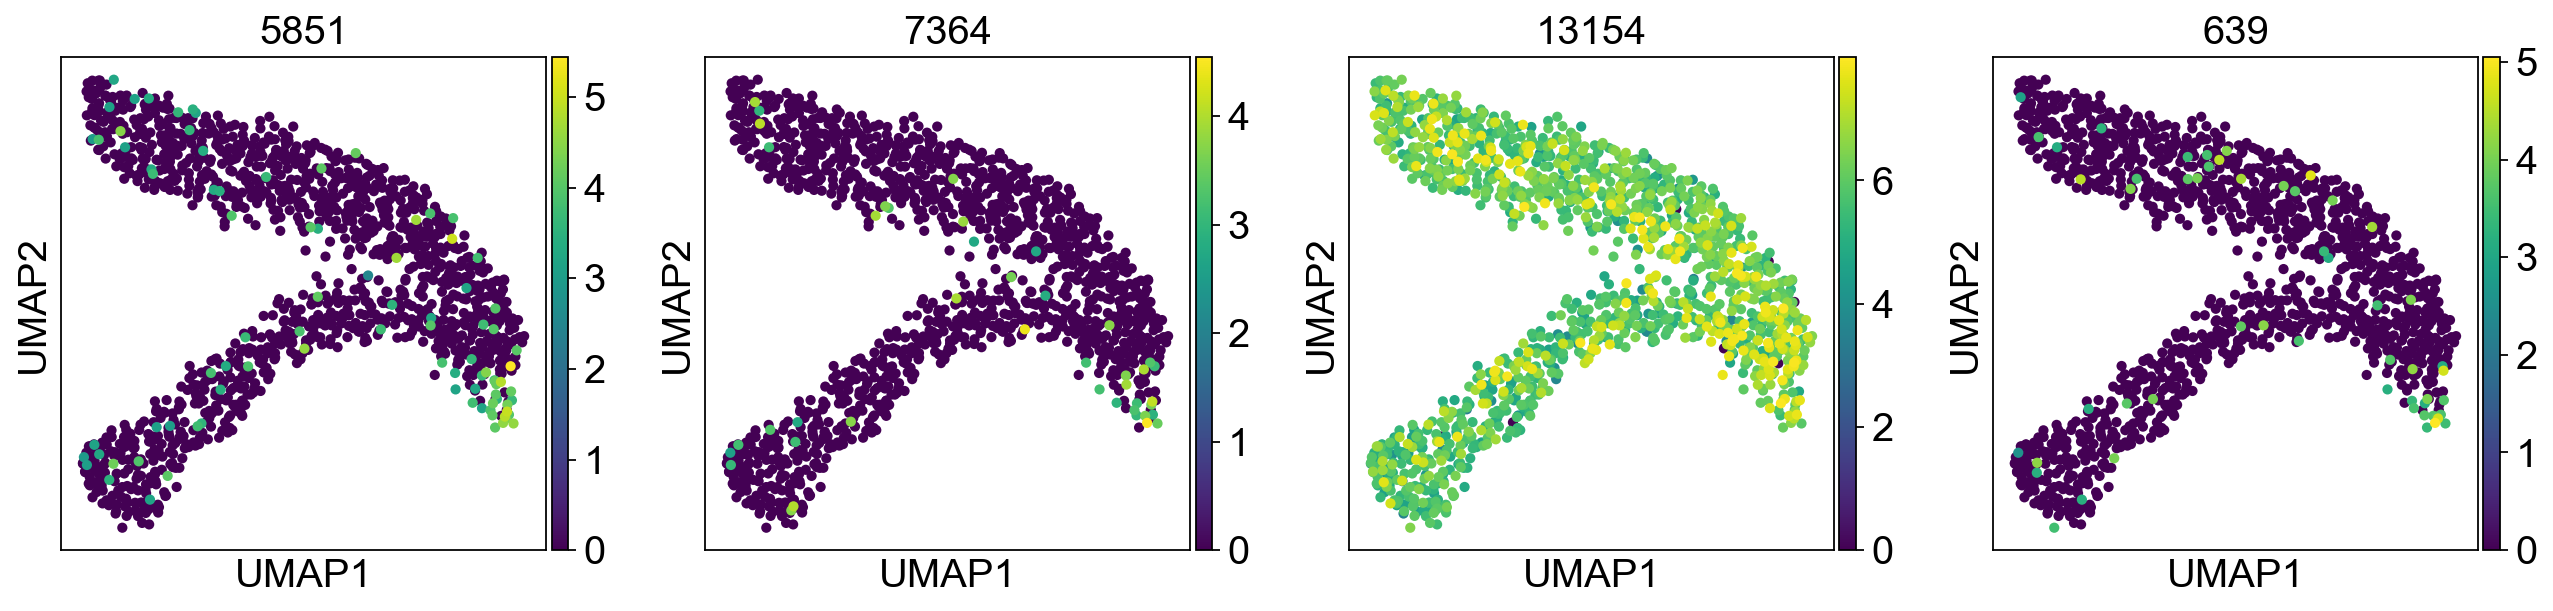

In [58]:
sc.pl.umap(adata_bc1ab_graph, color=adata_bc1b_ranked.var['conf_score_high'].sort_values(ascending=False).index[:4])
sc.pl.umap(adata_bc1ab_graph, color=adata_bc1a_ranked.var['conf_score_high'].sort_values(ascending=False).index[:4])
sc.pl.umap(adata_bc1ab_graph, color=adata_bc1ab_ranked.var['conf_score_low'].sort_values(ascending=False).index[:4])
